## BeerAdvocate: Descriptive Analysis and Processing

---

**Processing and Transformations Summary of "users.csv"**

- **Renaming Columns**: "nbr_ratings" to "n_ratings", "nbr_reviews" to "n_reviews", "user_id" to "uid", "user_name" to "username".
- **Converting Data Types**: "n_ratings", "n_reviews" to int & "username", "uid", "location" to str.
- **Converting "nan" to None**: in "location".
- **Creating an additional "country" column from "location"**: by extracting the country name from the location (example: "United States, Texas" location belongs to country "United States").
- **Converting the "joined" column values**: float values (time in seconds, reference is Jan.1st 1970 at 00:00) to pandas.Timestamp. Implicit conversion of NaN to NaT. 

---

**Descriptive Analysis Summary of "users.csv"**

* **Missing values**: none, except for "location" that may contain "nan" (previously converted to None) and "joined" that may contain NaN (previously implictely converted to NaT).

<br>

* **users**:
  - 153'704 unique users.
  - $\approx$ 20.3% of users are of unknown location.
  - most users are located in English speaking countries. top 5 countries in terms of number of users:
  
  | country | wrt to all users | wrt users with known location |
  | :- | :-: | :-: |
  | United States | 73.6% | 92.4% |
  | Canada | 2.1% | 2.7% |
  | England | 0.5% | 0.6% | 
  | Australia | 0.3% | 0.4% |
  | Germany | 0.2% | 0.3% |

<br>

* **ratings**:
  - 8'393'032 ratings in total.
  - heavy-tailed distribution of the number of ratings per user.
  - 50% of users have at most 3 ratings.
  - the mean number of ratings $\approx 54.6$ is quite low while the standard deviation $\approx 252.38$ is very high.
  - most rtings are given by users located in English speaking countries. Top 5 countries in terms of the number of ratings: 

  | country | wrt to all users | wrt users with known location |
  | :- | :-: | :-: |
  | United States | 87% | 92.5% |
  | Canada | 3.2% | 3.4% |
  | England | 0.4% | 0.5% | 
  | Australia | 0.4% | 0.4% |
  | Sweden | 0.3% | 0.3% |

<br>

* **reviews**:
  - reviews in total.
  - distribtion ?
  - 50% of users have 0 reviews.
  - the mean number of reviews $\approx 16.84$ is quite low while the standard deviation $\approx 139.84$ is very high.
  - most reviews are given by users from English speaking countries (US, Canada, Australia, England). Top 5 countries in terms of the number of reviews:
  
  | country | wrt to all users | wrt users with known location |
  | :- | :-: | :-: |
  | United States | 86.5% | 89.8% |
  | Canada | 4.8% | 5% |
  | Australia | 1% | 1% | 
  | England | 0.8% | 0.8% |
  | Netherlands | 0.3% | 0.3% |

<br>

* **joined**:
  - earliest year of joining: 1996.
  - latest year of joining: 2017 (date of the end of the collection of data, which happened between 2001 and 2017).
  - there are only 2652 users with unknown joining date.
  - the yearly by month distribution of users joining the plateform is not disrupted throughout most of the years (starting 2001 until 2017). 

<br>

* **country**:
  - users are located in 145 different countries.

---

In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

**setup**

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

### BeerAdvocate - users.csv

**[I] Loading the Data**

In [3]:
users_cols = [
    "nbr_ratings",
    "nbr_reviews",
    "user_id",
    "user_name",
    "joined",
    "location"]

users_df = ing.read_csv(
    path=ing.build_path(folderind="ba", fileind="users"),
    assume_missing=True,
    keepcols=users_cols)

users_df.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820.0,465.0,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521.0,2504.0,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797.0,1143.0,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31.0,31.0,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604.0,604.0,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


**[II] Data Transformation**

Renaming the columns

In [4]:
cols_renaming = {
    "nbr_ratings": "n_ratings",
    "nbr_reviews": "n_reviews",
    "user_id": "uid",
    "user_name": "username"
}

users_df = users_df.rename(columns=cols_renaming)
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location'], dtype='object')

Converting data types

In [5]:
users_df.dtypes

n_ratings    float64
n_reviews    float64
uid           object
username      object
joined       float64
location      object
dtype: object

In [6]:
users_dtypes = {
    "n_ratings": np.int32, 
    "n_reviews": np.int32, 
    "uid": str, 
    "username": str,
    "location": str
}

users_df = users_df.astype(users_dtypes)
users_df.dtypes

n_ratings      int32
n_reviews      int32
uid           object
username      object
joined       float64
location      object
dtype: object

Converting "nan" strings in "location" to None

In [7]:
users_df["location"] = users_df.location.apply(prc.str_nan_to_none)

c:\Users\Henrique\anaconda3\lib\site-packages\dask\dataframe\core.py:3858: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('location', 'object'))

  warnings.warn(meta_warning(meta))


Converting the "joined" column values (time in seconds) to Timestamps

In [8]:
users_df["joined"] = ddf.to_datetime(users_df.joined, unit="s")
users_df.head(5)

,n_ratings,n_reviews,uid,username,joined,location
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland


In [9]:
# CHECK
print("CHECK: max date year must be at most 2017, the last year data was collected.")
users_df.joined.max()

CHECK: max date year must be at most 2017, the last year data was collected.


dd.Scalar<series-..., type=Timestamp>

Appending the Country of Each Territory

In [10]:
users_df["country"] = users_df["location"].apply(lambda territory: prc.get_country(territory))
users_df.head(5)

c:\Users\Henrique\anaconda3\lib\site-packages\dask\dataframe\core.py:3858: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('location', 'object'))

  warnings.warn(meta_warning(meta))


,n_ratings,n_reviews,uid,username,joined,location,country
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland,Northern Ireland


**[III] Descriptive Statistics & Distributions**

In [12]:
users_df.describe()

,n_ratings,n_reviews
npartitions=1,,
,float64,float64
,...,...


user_id

In [13]:
print("Is any user ID missing ?")
users_df.uid.isna().any()

Is any user ID missing ?


dd.Scalar<series-..., dtype=bool>

In [14]:
print("How many unique users ?")
n_users = len(users_df.uid.unique())
n_users

How many unique users ?


153704

location

In [15]:
print("Is there a user with unknown location ?")
users_df.location.isna().any()

Is there a user with unknown location ?


dd.Scalar<series-..., dtype=bool>

In [16]:
print("How many users have an unknown location ?")
n_users_unknown_loc = users_df.location.isna().sum()
n_users_unknown_loc

How many users have an unknown location ?


dd.Scalar<series-..., dtype=int64>

In [17]:
print("What fraction do these users make up of the total number of users ?")
n_users_unknown_loc / n_users

What fraction do these users make up of the total number of users ?


dd.Scalar<truediv..., dtype=float64>

In [18]:
print("Where are all users located ?")
all_countries = users_df.country[~users_df.country.isna()].unique()
all_countries.sort()
all_countries

Where are all users located ?


AttributeError: 'Series' object has no attribute 'sort'

In [19]:
print("How many different locations are there ?")
len(all_countries)

How many different locations are there ?


145

In [20]:
n_users_per_country_wout_us = users_df[\
    (~users_df.country.isna()) &\
    (users_df.country != "United States")].groupby("country", as_index=False).size()

fig, ax = plt.subplots(1,1)
ax.set_title("Number of Users Across All Countries except the US")
ax.set_ylabel("users' count")
ax.set_xlabel("country (represented via its index entry)")
sns.scatterplot(data=n_users_per_country_wout_us, ax=ax, s=10)

TypeError: __init__() got an unexpected keyword argument 'as_index'

In [21]:
print("List of countries with at least 100 users")
n_users_per_country = users_df.groupby("country", as_index=False).size()
countries_atleast_100users = n_users_per_country[n_users_per_country["size"] >= 100]
countries_atleast_100users["users_frac"] = countries_atleast_100users["size"] / users_df.location[~ users_df.location.isna()].size
countries_atleast_100users = countries_atleast_100users.sort_values(by="size", ascending=False)
countries_atleast_100users

List of countries with at least 100 users


TypeError: __init__() got an unexpected keyword argument 'as_index'

n_ratings

In [22]:
print("Is there a user with unknown number of ratings ?")
users_df.n_ratings.isna().any()

Is there a user with unknown number of ratings ?


dd.Scalar<series-..., dtype=bool>

In [23]:
print("Total number of ratings")
total_n_ratings = users_df.n_ratings.sum()
total_n_ratings

Total number of ratings


dd.Scalar<series-..., dtype=int64>

<AxesSubplot:title={'center':'Distribution of Ratings Across All Users'}, xlabel='ratings', ylabel='occurences'>

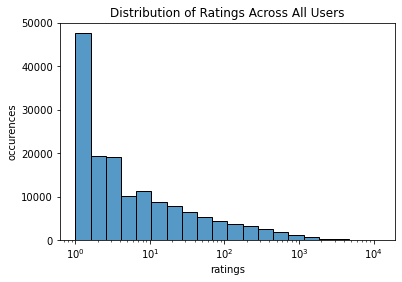

In [24]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of Ratings Across All Users")
ax.set_ylabel("occurences")
ax.set_xlabel("ratings")
sns.histplot(data=users_df, x="n_ratings", ax=ax, bins=20, log_scale=True)


In [25]:
n_ratings_per_country = users_df[\
    (~users_df.country.isna()) &\
    (users_df.country != "United States")].groupby("country", as_index=False).agg({"n_ratings": np.sum})

fig, ax = plt.subplots(1,1)
ax.set_title("Number of Ratings Across All Countries except the US")
ax.set_ylabel("ratings' count")
ax.set_xlabel("country (represented by its entry index)")
sns.scatterplot(data=n_ratings_per_country, ax=ax, s=10)

TypeError: __init__() got an unexpected keyword argument 'as_index'

In [26]:
print("List of countries with at least 10'000 ratings")
min_n_ratings = 10_000
n_ratings_per_country = users_df[~users_df.country.isna()].groupby("country", as_index=False).agg({"n_ratings": np.sum})
countries_atleast_10Kratings = n_ratings_per_country[n_ratings_per_country.n_ratings >= min_n_ratings]
countries_atleast_10Kratings["ratings_frac"] = countries_atleast_10Kratings.n_ratings / users_df[~users_df.country.isna()].n_ratings.sum()
countries_atleast_10Kratings = countries_atleast_10Kratings.sort_values(by="n_ratings", ascending=False)
countries_atleast_10Kratings

List of countries with at least 10'000 ratings


TypeError: __init__() got an unexpected keyword argument 'as_index'

n_reviews

In [27]:
print("Is there a user with unknown number of reviews ?")
users_df.n_reviews.isna().any()

Is there a user with unknown number of reviews ?


dd.Scalar<series-..., dtype=bool>

In [28]:
print("Total number of reviews")
total_n_reviews = users_df.n_reviews.sum()
total_n_reviews

Total number of reviews


dd.Scalar<series-..., dtype=int64>

c:\Users\Henrique\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Distribution of Reviews Across All Users'}, xlabel='reviews', ylabel='occurences'>

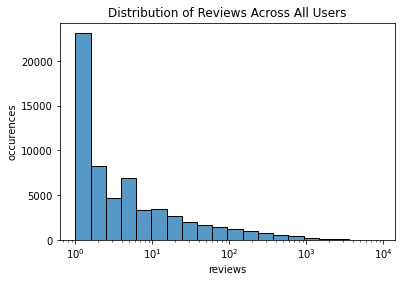

In [29]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of Reviews Across All Users")
ax.set_ylabel("occurences")
ax.set_xlabel("reviews")
sns.histplot(data=users_df, x="n_reviews", ax=ax, bins=20, log_scale=True)

In [30]:
print("List of countries with at least 5'000 reviews")
min_n_reviews = 5_000
n_reviews_per_country = users_df[~users_df.country.isna()].groupby("country", as_index=False).agg({"n_reviews": np.sum})
countries_atleast_5Kreviews = n_reviews_per_country[n_reviews_per_country.n_reviews >= min_n_reviews]
countries_atleast_5Kreviews["reviews_frac"] = countries_atleast_5Kreviews.n_reviews /\
    users_df.n_reviews[~users_df.country.isna()].sum()
countries_atleast_5Kreviews = countries_atleast_5Kreviews.sort_values(by="n_reviews", ascending=False)
countries_atleast_5Kreviews

List of countries with at least 5'000 reviews


TypeError: __init__() got an unexpected keyword argument 'as_index'

joined

In [31]:
print("Is there any missing joining date ?")
users_df.joined.isna().any()

Is there any missing joining date ?


dd.Scalar<series-..., dtype=bool>

In [32]:
print("How many users have unknown joining date ?")
users_df.joined.isna().sum()

How many users have unknown joining date ?


dd.Scalar<series-..., dtype=int64>

TypeError: __init__() got an unexpected keyword argument 'as_index'

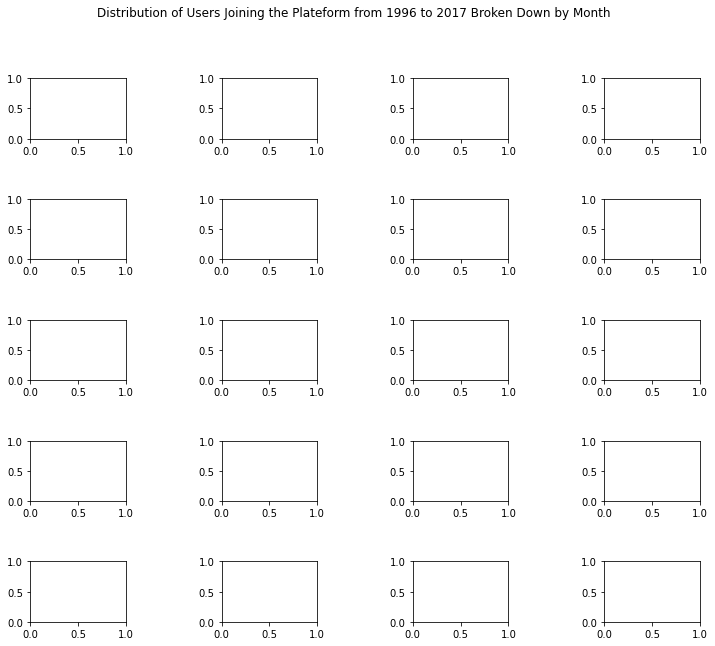

In [33]:
fig, axs = plt.subplots(5, 4, figsize=(12,10))
plt.subplots_adjust(wspace=1, hspace=1)
fig.suptitle("Distribution of Users Joining the Plateform from 1996 to 2017 Broken Down by Month")
users_joined_by_year = users_df.groupby(users_df.joined.dt.year, as_index=False)
for i, (year, by_year) in enumerate(users_joined_by_year):
    a = int(i/4); b = i % 4
    ax = axs[a][b]
    ax.set_title("year %d"%(year))
    users_joined_by_month = by_year.groupby(by_year.joined.dt.month, as_index=False).size()
    sns.barplot(data=users_joined_by_month, x="joined", y="size", color="blue", ax=ax, orient="v")

# Location based statistics

In [55]:
# compute number of users per state (US only)
n_users_per_state = users_df[users_df.country == "United States"].groupby("location").size()

# keep only states with at least 100 users
min_n_users = 1000
n_users_per_state_top = n_users_per_state[n_users_per_state >= min_n_users]

# print the number of states with less than 100 users
print("Number of states with less than {0} users: {1}".format(min_n_users,
    n_users_per_state.size.compute() - n_users_per_state_top.size.compute()))


Number of states with less than 1000 users: 21


<AxesSubplot:title={'center':'Distribution of number of users per state (US only) with at least 1000 users'}, xlabel='location', ylabel='nbr_users'>

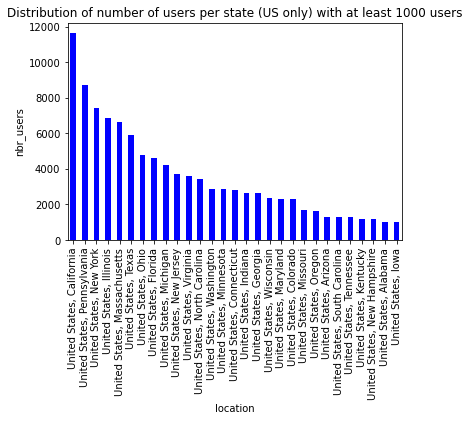

In [57]:
# sort states by number of users
#n_users_per_state_100 = n_users_per_state_100.sort_values(ascending=False)

fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of number of users per state (US only) with at least {0} users".format(min_n_users))
ax.set_ylabel("nbr_users")
ax.set_xlabel("state")

n_users_per_state_top.compute().sort_values(ascending=False).plot.bar(ax=ax, color="blue")

In [66]:
# compute number of ratings per state (US only)
users_per_state = users_df[users_df.country == "United States"].groupby("location")
nb_rating_per_state = users_per_state.aggregate({"n_ratings": np.sum}).squeeze()

<AxesSubplot:title={'center':'Distribution of number of number of ratings per state (US only)'}, xlabel='location', ylabel='nbr_users'>

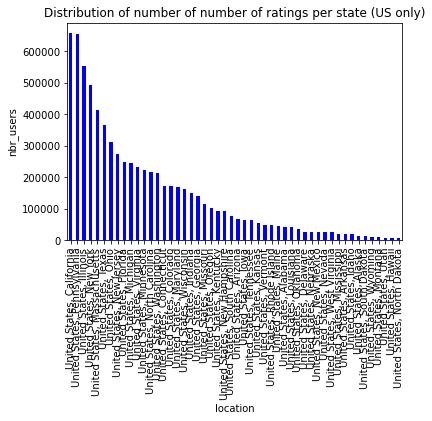

In [78]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of number of number of ratings per state (US only)")
ax.set_ylabel("nbr_ratings")
ax.set_xlabel("state")
nb_rating_per_state.compute().sort_values(ascending=False).plot.bar(ax=ax, color="blue")

<AxesSubplot:title={'center':'Distribution of ratio of number of ratings per number of users ofr each state (US only)'}, xlabel='location', ylabel='nbr_ratings'>

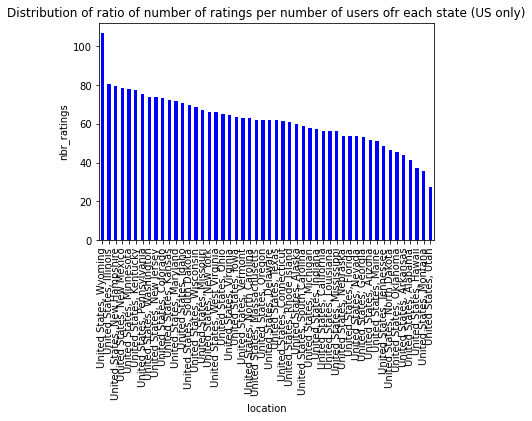

In [80]:
# number ratings divided by number of users for each state
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of ratio of number of ratings per number of users ofr each state (US only)")
ax.set_ylabel("nbr_ratings")
ax.set_xlabel("state")
n_rating_state_ratio = nb_rating_per_state / n_users_per_state
n_rating_state_ratio.compute().sort_values(ascending=False).plot.bar(ax=ax, color="blue")

In [75]:
users_df.n_ratings.mean().compute()

54.60516317076979

In [83]:
ratings_ddf = prc.ratings_pipeline(prc.users_pipeline())
ratings_ddf.head(5)

,date,bid,uid,appearance,aroma,palate,taste,overall,rating,has_review,review
0,2015-08-20 10:00:00,142544.0,nmann08.184925,3.25,2.75,3.25,2.75,3.00,2.88,True,"From a bottle, pours a piss yellow color with ..."
1,2015-11-14 11:00:00,120824.0,nmann08.184925,4.00,3.50,3.75,3.50,3.50,3.56,False,None
2,2011-11-18 11:00:00,47581.0,nmann08.184925,NaN,NaN,NaN,NaN,NaN,4.50,False,None
3,2013-05-03 10:00:00,93113.0,nmann08.184925,NaN,NaN,NaN,NaN,NaN,3.75,False,None
4,2015-01-24 11:00:00,875.0,nmann08.184925,4.00,3.50,3.75,4.00,3.75,3.81,False,None


In [84]:
user_ratings = users_df.merge(ratings_ddf, left_on="uid", right_on="uid")
user_ratings.head(10)

,n_ratings,n_reviews,uid,username,joined,location,country,date,bid,appearance,aroma,palate,taste,overall,rating,has_review,review
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2015-08-20 10:00:00,142544.0,3.25,2.75,3.25,2.75,3.00,2.88,True,"From a bottle, pours a piss yellow color with ..."
1,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2015-11-14 11:00:00,120824.0,4.00,3.50,3.75,3.50,3.50,3.56,False,None
2,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2011-11-18 11:00:00,47581.0,NaN,NaN,NaN,NaN,NaN,4.50,False,None
3,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2013-05-03 10:00:00,93113.0,NaN,NaN,NaN,NaN,NaN,3.75,False,None
4,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2015-01-24 11:00:00,875.0,4.00,3.50,3.75,4.00,3.75,3.81,False,None
5,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2012-02-07 11:00:00,52610.0,NaN,NaN,NaN,NaN,NaN,3.50,False,None
6,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2012-02-07 11:00:00,12719.0,NaN,NaN,NaN,NaN,NaN,2.50,False,None
7,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2012-02-07 11:00:00,77595.0,NaN,NaN,NaN,NaN,NaN,2.50,False,None
8,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2012-02-07 11:00:00,39258.0,NaN,NaN,NaN,NaN,NaN,3.00,False,None
9,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,2016-08-20 10:00:00,236196.0,4.00,4.25,4.00,4.00,4.00,4.06,False,None


In [91]:
# average rating across all users
avg_ratings_all = user_ratings[["uid", "rating"]].groupby("uid").agg('mean')
avg_ratings_all.compute().mean()

rating    4.038979
dtype: float64

In [95]:
# average rating per country
avg_ratings_country = user_ratings[["rating", "country"]].groupby("country").agg('mean')
avg_ratings_country.head(10)

,rating
country,
Australia,3.617526
Canada,3.739052
England,3.684480
United States,3.896614


Task exception was never retrieved
future: <Task finished name='Task-2802' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\Henrique\anaconda3\lib\site-packages\distributed\client.py:1994> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\Henrique\anaconda3\lib\site-packages\distributed\client.py", line 1999, in wait
    raise AllExit()
distributed.client.AllExit


In [102]:
user_ratings_usa = user_ratings[user_ratings.country == "United States"]
avg_ratings_states = user_ratings_usa[["rating", "location"]].groupby("location").agg('mean')

In [104]:
avg_ratings_states.head(50)

,rating
location,
"United States, Alabama",3.825257
"United States, Alaska",3.939863
"United States, Arizona",3.905700
"United States, Arkansas",3.852708
"United States, California",3.937874
"United States, Colorado",3.894112
"United States, Connecticut",3.943980
"United States, Delaware",3.934253
"United States, Florida",3.901896
